In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import h5py
import os
file_dir = os.getcwd()

In [28]:
# 读取 hdf5 文件中的动作数据
def read_libero_data(file_path):
    with h5py.File(file_path, 'r') as f:
        actions = f['action'][()][:, 0:7]  # 只取前7维
    actions = torch.from_numpy(actions)  # 转为 torch 张量
    return actions

In [29]:
# 绘制动作的频谱图和时域图
def plot_action_spectrum(actions: torch.Tensor, sample_rate=1.0, lowpass_cutoff=None, max_freq=None):
    assert actions.ndim == 2, "actions 必须是 (length, action_dim) 形状"
    length, action_dim = actions.shape
    actions_np = actions.cpu().numpy()  # 转为 numpy 数组

    freqs = np.fft.fftfreq(length, d=1 / sample_rate)  # 计算频率轴
    pos_mask = freqs >= 0  # 只保留正频率部分
    freqs = freqs[pos_mask]

    # 创建子图，每个动作维度两列（频谱+时域）
    fig, axs = plt.subplots(action_dim, 2, figsize=(12, 3.5 * action_dim), sharex=False)

    if action_dim == 1:
        axs = [axs]  # 保证 axs 可迭代

    time_axis = np.linspace(0, length / sample_rate, num=length)  # 生成时间轴

    for i in range(action_dim):
        signal = actions_np[:, i]  # 取第 i 个动作维度

        # 如果设置了低通滤波，则先滤波
        if lowpass_cutoff is not None and lowpass_cutoff < sample_rate / 2:
            sos = scipy.signal.butter(N=4, Wn=lowpass_cutoff, fs=sample_rate, btype='low', output='sos')
            signal = scipy.signal.sosfilt(sos, signal)

        fft_vals = np.fft.fft(signal)  # 傅里叶变换
        magnitude = np.abs(fft_vals)[pos_mask]  # 取幅值，只保留正频率

        peak_idx = np.argmax(magnitude[1:]) + 1  # 找到主峰（跳过直流分量）
        peak_freq = freqs[peak_idx]
        peak_mag = magnitude[peak_idx]

        # 绘制频谱图
        axs[i, 0].plot(freqs, magnitude, color='steelblue', lw=2)
        axs[i, 0].scatter([peak_freq], [peak_mag], color='crimson', label=f'Peak: {peak_freq:.2f} Hz')
        axs[i, 0].set_title(f"Action Dimension {i} - Frequency Spectrum", fontsize=9)
        axs[i, 0].set_xlabel("Frequency (Hz)", fontsize=9)
        axs[i, 0].set_ylabel("Magnitude", fontsize=9)
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.5)
        axs[i, 0].tick_params(axis='both', labelsize=6)

        if max_freq is not None:
            axs[i, 0].set_xlim(0, max_freq)  # 限制最大频率显示范围

        # 绘制时域图
        axs[i, 1].plot(time_axis, signal, color='darkgreen', lw=2)
        axs[i, 1].set_title(f"Action Dimension {i} - Time Domain", fontsize=9)
        axs[i, 1].set_ylabel("Amplitude", fontsize=9)
        axs[i, 1].set_xlabel("Time (s)", fontsize=9)
        axs[i, 1].set_xlim(time_axis[0], time_axis[-1])
        axs[i, 1].grid(True, linestyle='--', alpha=0.5)
        axs[i, 1].tick_params(axis='both', labelsize=6)

    axs[-1, 0].set_xlabel("Frequency (Hz)", fontsize=9)  # 最后一行加 x 轴标签

    fig.subplots_adjust(top=0.95, bottom=0.1, left=0.08, right=0.97, hspace=0.5)  # 调整子图间距
    return fig

# 更新绘图区域
def update_plot(actions, sample_rate, lowpass_cutoff, max_freq):
    for widget in canvas_frame.winfo_children():
        widget.destroy()  # 清空原有图像

    fig = plot_action_spectrum(actions, sample_rate, lowpass_cutoff, max_freq)  # 生成新图
    canvas = FigureCanvasTkAgg(fig, master=canvas_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)


In [30]:
# 主界面函数
def main_ui():
    def on_update_plot():
        # actions = read_libero_data(file_dir + '/data/actions_left_demo1.hdf5')
        actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
        # actions = read_libero_data('/Users/zeen/study/AR/data/episode_0.hdf5')  # 读取数据
        # actions = torch.randn([400,5])  # 可用于测试
        sample_rate = float(sample_rate_entry.get())
        lowpass_cutoff = float(lowpass_cutoff_entry.get()) if lowpass_cutoff_entry.get() else None
        max_freq = float(desired_max_freq_entry.get()) if desired_max_freq_entry.get() else None
        update_plot(actions, sample_rate, lowpass_cutoff, max_freq)  # 更新图像

    root = tk.Tk()
    root.title("动态频谱图绘制")
    root.geometry("1000x700")

    main_frame = tk.Frame(root)
    main_frame.pack(fill=tk.BOTH, expand=True)

    control_frame = tk.Frame(main_frame)
    control_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=10)

    global canvas_frame
    canvas_frame = tk.Frame(main_frame, pady=10)
    canvas_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

    # 控件：采样率
    tk.Label(control_frame, text="Sample Rate (Hz)").grid(row=0, column=0, padx=5, pady=5)
    sample_rate_entry = tk.Entry(control_frame)
    sample_rate_entry.grid(row=0, column=1, padx=5, pady=5)
    sample_rate_entry.insert(0, "50")

    # 控件：低通滤波截止频率
    tk.Label(control_frame, text="Lowpass Cutoff (Hz)").grid(row=0, column=2, padx=5, pady=5)
    lowpass_cutoff_entry = tk.Entry(control_frame)
    lowpass_cutoff_entry.grid(row=0, column=3, padx=5, pady=5)
    lowpass_cutoff_entry.insert(0, "25")

    # 控件：最大频率显示
    tk.Label(control_frame, text="Max Frequency (Hz)").grid(row=0, column=4, padx=5, pady=5)
    desired_max_freq_entry = tk.Entry(control_frame)
    desired_max_freq_entry.grid(row=0, column=5, padx=5, pady=5)
    desired_max_freq_entry.insert(0, "25")

    # 确认按钮
    button = tk.Button(control_frame, text="确认", command=on_update_plot)
    button.grid(row=0, column=6, padx=5, pady=5)

    root.mainloop()

In [ ]:
main_ui()
# action from aloha env: ["waist", "s", "elbow", "forearm_roll", "wrist_angle", "wrist_rotate"]

In [31]:
def plot_action_static_with_spectrum(actions: torch.Tensor, sample_rate=1.0, max_freq=None):
    """
    绘制动作信号的静态时域图和频谱图

    参数:
        actions: torch.Tensor, 形状为 (length, action_dim)
        sample_rate: 采样率 (Hz)
        max_freq: 频谱图最大显示频率 (Hz)，可选
    """
    assert actions.ndim == 2, "actions 必须是 (length, action_dim) 形状"
    length, action_dim = actions.shape
    actions_np = actions.cpu().numpy()
    time_axis = np.linspace(0, length / sample_rate, num=length)
    freqs = np.fft.fftfreq(length, d=1 / sample_rate)
    pos_mask = freqs >= 0
    freqs = freqs[pos_mask]

    fig, axs = plt.subplots(action_dim, 2, figsize=(12, 3 * action_dim), sharex=False)
    if action_dim == 1:
        axs = [axs]

    for i in range(action_dim):
        signal = actions_np[:, i]
        # 时域图
        axs[i][0].plot(time_axis, signal, color='royalblue', lw=2)
        axs[i][0].set_ylabel(f"Dim {i}", fontsize=9)
        axs[i][0].set_title(f"Action {i} - Time Domain", fontsize=10)
        axs[i][0].grid(True, linestyle='--', alpha=0.5)
        axs[i][0].tick_params(axis='both', labelsize=8)
        # 频谱图
        fft_vals = np.fft.fft(signal)
        magnitude = np.abs(fft_vals)[pos_mask]
        axs[i][1].plot(freqs, magnitude, color='darkorange', lw=2)
        axs[i][1].set_title(f"Action {i} - Spectrum", fontsize=10)
        axs[i][1].set_xlabel("Frequency (Hz)", fontsize=9)
        axs[i][1].set_ylabel("Magnitude", fontsize=9)
        axs[i][1].grid(True, linestyle='--', alpha=0.5)
        axs[i][1].tick_params(axis='both', labelsize=8)
        if max_freq is not None:
            axs[i][1].set_xlim(0, max_freq)

    axs[-1][0].set_xlabel("Time (s)", fontsize=10)
    fig.suptitle("Action Signal: Time Domain & Spectrum", fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

In [33]:
actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
print(f"action shape: {actions.shape}")
# print(f"actions: {actions}")

action shape: torch.Size([400, 7])


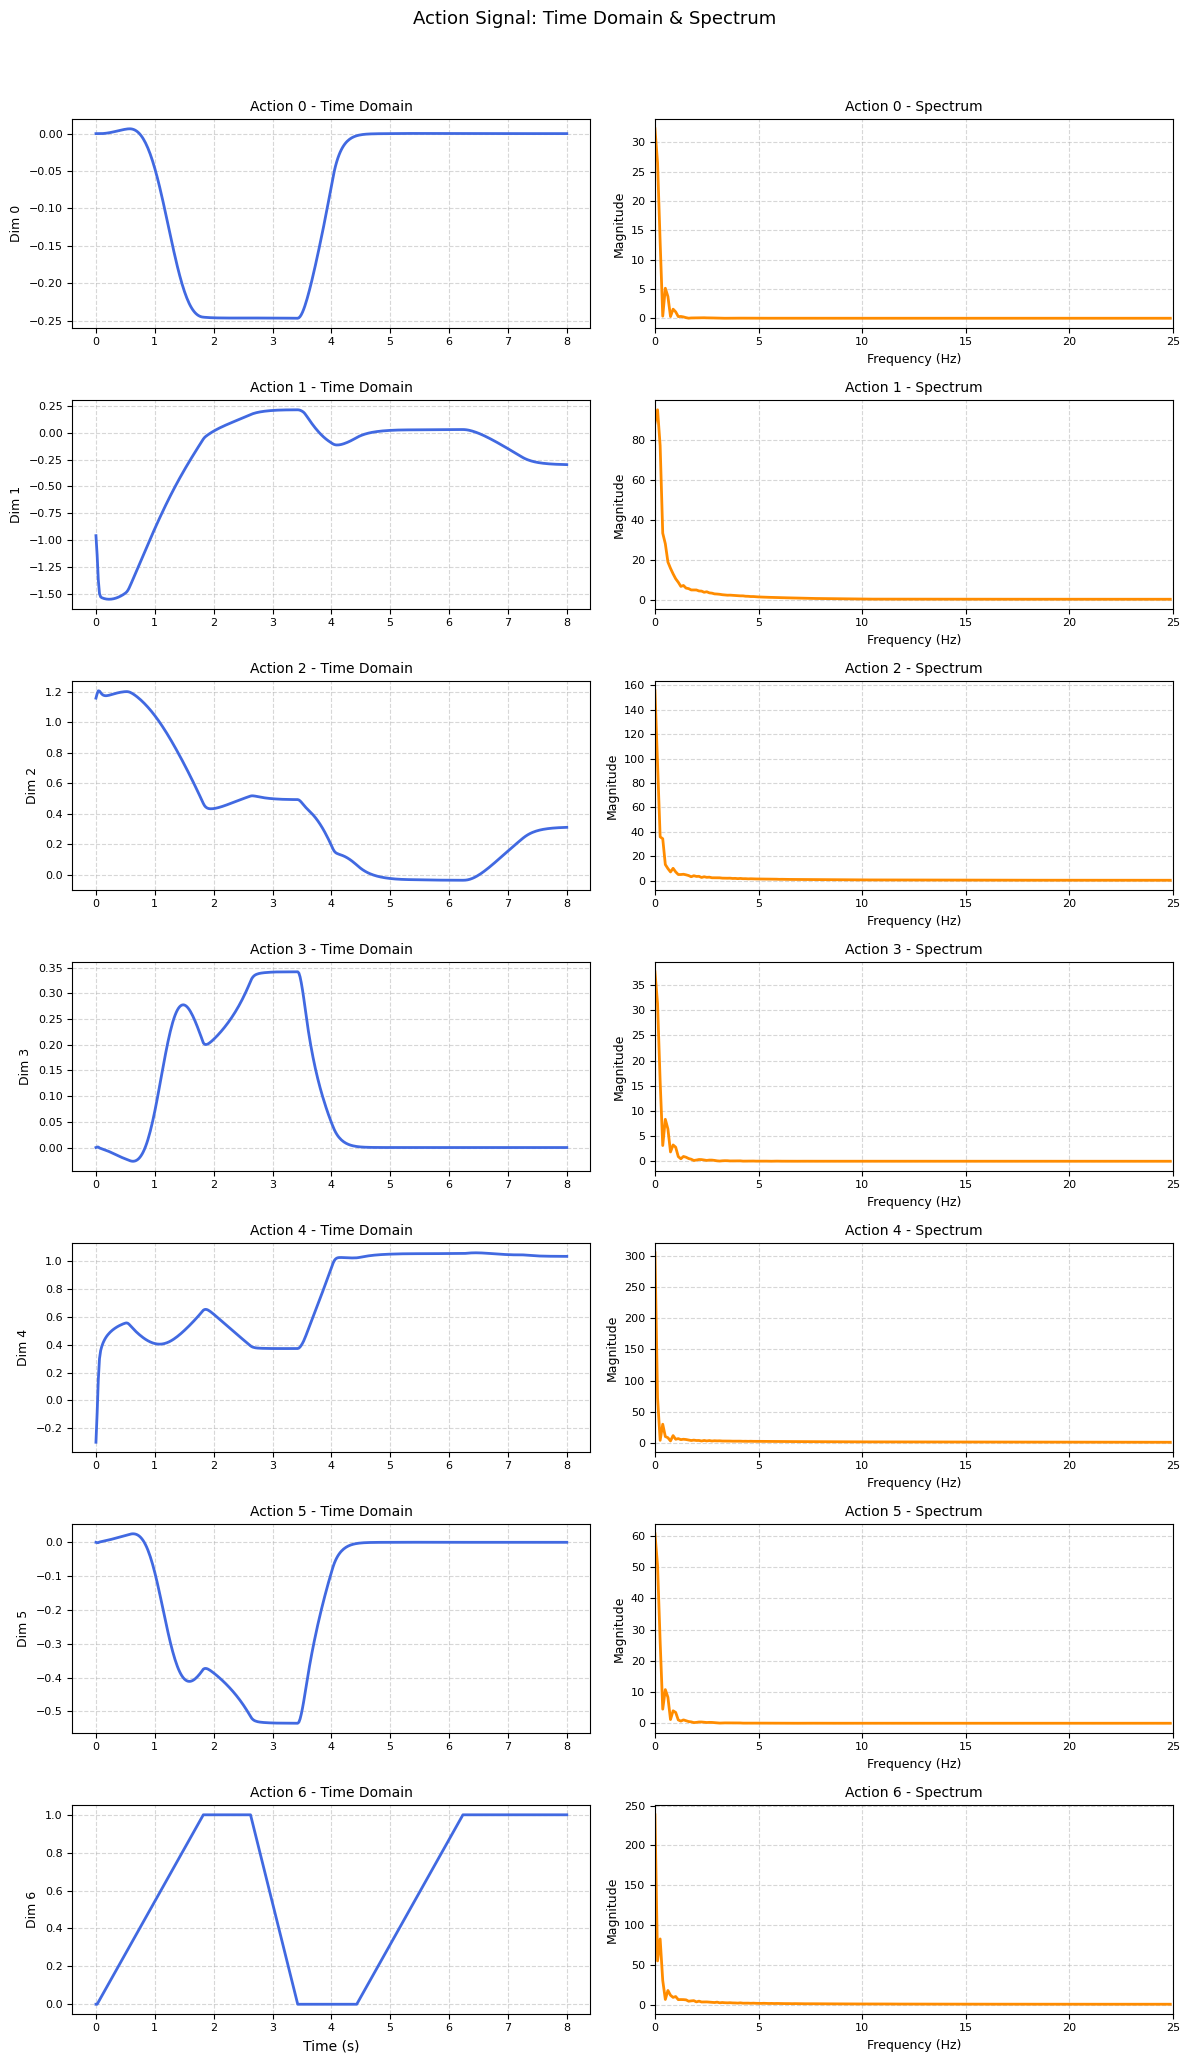

In [36]:
actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
fig = plot_action_static_with_spectrum(actions, sample_rate=50, max_freq=25)
plt.show()

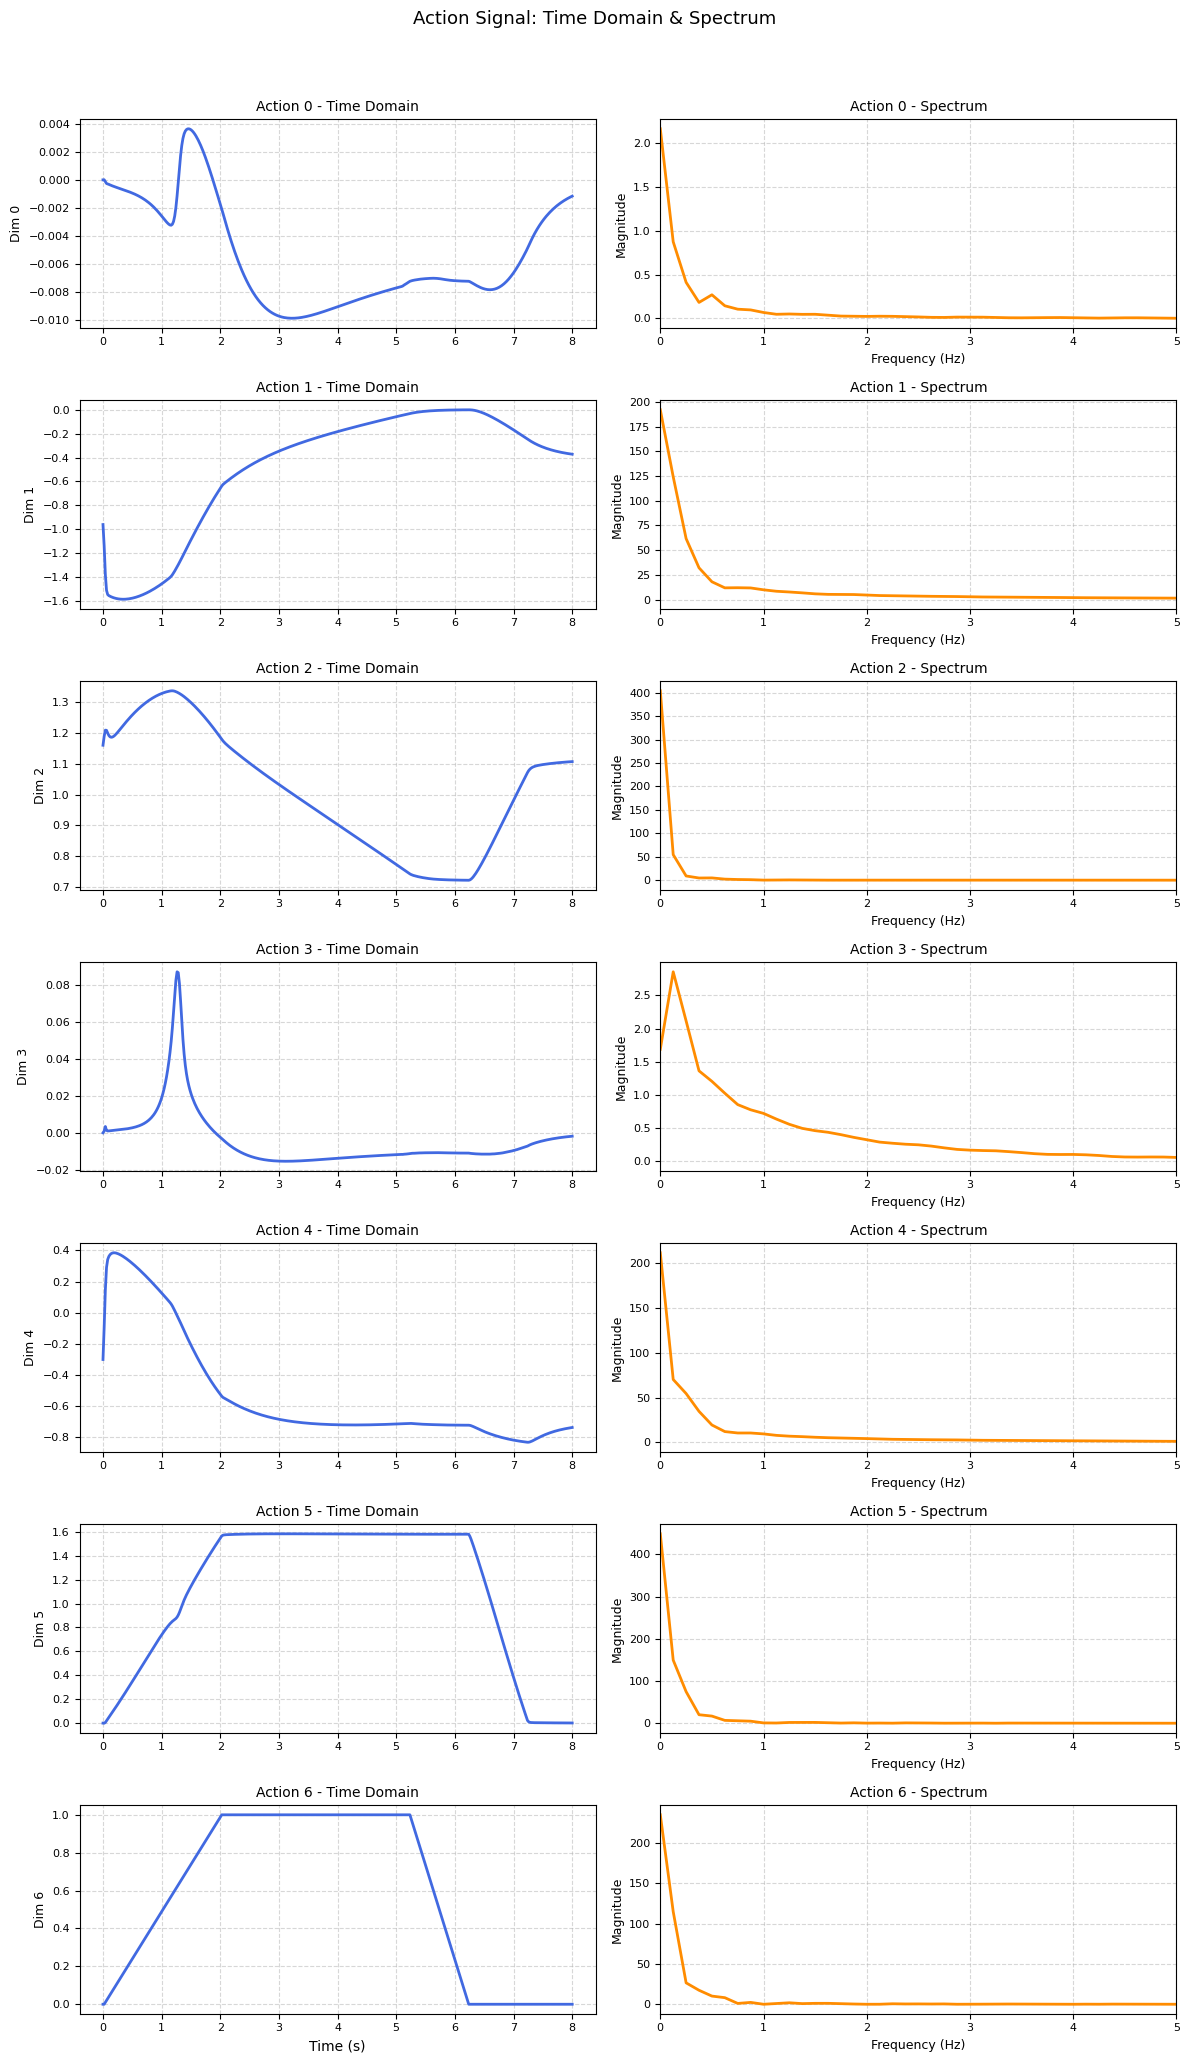

In [37]:
actions = read_libero_data(file_dir + '/data/actions_left_demo1.hdf5')
fig = plot_action_static_with_spectrum(actions, sample_rate=50, max_freq=5)
plt.show()